# Femme au volant, mort au tournant ?

## Introduction

Question bien fâcheuse que celle de la mortalité des véhicules à roues. Plus particulièrement, des facteurs influençant ces risques. Si notre enfance a été bercée de slogans douteux concernant la conduite, à l'instar du fameux "Femme au volant, mort au tournant", est-il statistiquement plus probable qu'une femme cause un accident mortel qu'un homme ? 

Au cours de ce projet, nous cherchons à analyser si, à caractéristiques comparables, le genre du conducteur est associé à une différence de gravité dans les accidents de la route en France en 2024. 
Nous reprenons ici la définition d'accident de la route de l'Arrêté du 27 mars 2007 relatif aux conditions d’élaboration des statistiques relatives aux accidents corporels de la circulation : "Un accident corporel de la circulation routière
- provoque la mort ou la blessure d'une ou plusieurs personnes,
- survient sur une voie ouverte à la circulation publique (code de la route),
- en excluant les actes volontaires (homicides volontaires, suicides...) et les catastrophes naturelles.
- implique au moins un véhicule roulant ou se déplaçant."

Nous nous basons sur les données collectées par le *Ministère de l'Intérieur* sur l'année 2024, disponibles sur le site data.gouv à *[l'adresse suivante](https://www.data.gouv.fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024)*. Plus précisément, nous avons choisi les fichiers concernant respectivement les caractéristiques spatio-temporelles des accidents, et les caractéristiques des conducteurs comme l'*âge* et le *sexe*. Comme nous le détaillerons plus loin, ces données s'avèrent propres, et nécessitent peu de travail de nettoyage.

Nous amorcerons notre analyse par des visualisation, qui servira une analyse descriptive, et où nous pourrons constater quelques faits intéressants sur les accidents de la route. Ensuite, nous construirons et comparerons différents outils de modélisation de la gravité d'un potentiel accident. Nous commencerons par plusieurs régressions linéaires et logistiques, et une random forest. Notre objectif final est de développer un réseau neuronal permettant de prédire la mortalité d'une situation en fonction de données connues par le conducteur.


## Récupération, nettoyage et enrichissement de la base de données

On commence par importer les librairies et les données. Ces dernières sont mises à disposition par l'Observatoire national interministériel de la sécurité routière (ONISR). Elles ont été récupérées via le site data.gouv.fr.

In [191]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import time, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [168]:
df_c = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv', encoding="utf-8", sep=';', engine='python')
df_u = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115506/usagers-2024.csv', encoding="utf-8", sep=';', engine='python')

In [214]:
df_c.info()
df_c.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54402 entries, 0 to 54401
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  54402 non-null  int64 
 1   jour     54402 non-null  int64 
 2   mois     54402 non-null  int64 
 3   an       54402 non-null  int64 
 4   hrmn     54402 non-null  object
 5   lum      54402 non-null  int64 
 6   dep      54402 non-null  object
 7   com      54402 non-null  object
 8   agg      54402 non-null  int64 
 9   int      54402 non-null  int64 
 10  atm      54402 non-null  int64 
 11  col      54402 non-null  int64 
 12  adr      52092 non-null  object
 13  lat      54402 non-null  object
 14  long     54402 non-null  object
dtypes: int64(9), object(6)
memory usage: 6.2+ MB


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,5,1,D438,"47,56277000","6,75832000"
1,202400000002,20,3,2024,15:05,1,21,21054,2,3,7,6,HOTEL DIEU (RUE DE L'),"47,02109000","4,83755000"
2,202400000003,22,3,2024,19:30,2,15,15012,1,1,1,6,Allée des Tilleuls,"44,90238400","2,49641800"
3,202400000004,24,3,2024,17:50,1,14,14118,2,3,7,3,128 Rue d'Authie,"49,19166000","-0,39851000"
4,202400000005,25,3,2024,19:35,5,13,13106,1,3,2,5,BEDOULE (CHEMIN DE LA),"43,39000000","5,35000000"


In [215]:
df_u.info()
df_u.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125187 entries, 0 to 125186
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125187 non-null  int64  
 1   id_usager    125187 non-null  object 
 2   id_vehicule  125187 non-null  object 
 3   num_veh      125187 non-null  object 
 4   place        125187 non-null  int64  
 5   catu         125187 non-null  int64  
 6   grav         125187 non-null  int64  
 7   sexe         125187 non-null  int64  
 8   an_nais      122608 non-null  float64
 9   trajet       125187 non-null  int64  
 10  secu1        125187 non-null  int64  
 11  secu2        125187 non-null  int64  
 12  secu3        125187 non-null  int64  
 13  locp         125187 non-null  int64  
 14  actp         125187 non-null  object 
 15  etatp        125187 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.3+ MB


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202400000001,203 988 581,155 781 758,A01,1,1,3,1,2003.0,2,1,-1,-1,-1,-1,-1
1,202400000001,203 988 582,155 781 759,B01,1,1,1,1,1997.0,4,1,-1,-1,-1,-1,-1
2,202400000002,203 988 579,155 781 757,A01,10,3,3,2,1927.0,5,0,-1,-1,3,3,1
3,202400000002,203 988 580,155 781 757,A01,1,1,1,1,1987.0,4,1,0,-1,3,3,1
4,202400000003,203 988 574,155 781 756,A01,2,2,4,2,2007.0,5,8,0,-1,-1,-1,-1


On remarque que bien que les deux tables puissent être concaténées par le biais de la variable de jointure 'Num_Acc', elles ne contiennent pas la même quantité de données : chacune contient entre 54000 et 126000 lignes. Etudions chaque table plus en détails :

### Table 'caract-2024' (df_c)

In [145]:
nb = df_c.isna().any(axis=1).sum()
print(nb)

2310


In [147]:
nb = df_c.drop(columns=['adr']).isna().any(axis=1).sum()
print(nb)

0


Les valeurs manquantes concernent la colonne 'adr' (adresse). Nous n'utiliserons pas cette variable dans notre analyse ; nous gardons donc la table "caractéristiques" en l'état.

### Table 'usagers-2024' (df_u)

In [150]:
nb = df_u.isna().any(axis=1).sum()
print(nb)

2579


In [151]:
nb = df_u.drop(columns=['an_nais']).isna().any(axis=1).sum()
print(nb)

0


Ici, on remarque que les valeurs manquantes concernent la colonne 'an_nais' (année de naissance). Cette souhaitons utiliser cette variable dans notre analyse. Comme il ne manque que 25000 valeurs sur 125000 (soit deux pourcents environ), nous nous permettons de supprimer les lignes concernées.

### Concaténation et création de nouvelles variables

In [176]:
df_cu = pd.merge(df_c, df_u, on='Num_Acc', how='outer')

nb_vides_par_col = df_cu.isna().sum()
print(nb_vides_par_col)

Num_Acc           0
jour              0
mois              0
an                0
hrmn              0
lum               0
dep               0
com               0
agg               0
int               0
atm               0
col               0
adr            5679
lat               0
long              0
id_usager         0
id_vehicule       0
num_veh           0
place             0
catu              0
grav              0
sexe              0
an_nais        2579
trajet            0
secu1             0
secu2             0
secu3             0
locp              0
actp              0
etatp             0
dtype: int64


In [177]:
df_cu = df_cu.dropna(subset=['an_nais'])

nb_vides_par_col = df_cu.isna().sum()
print(nb_vides_par_col)

Num_Acc           0
jour              0
mois              0
an                0
hrmn              0
lum               0
dep               0
com               0
agg               0
int               0
atm               0
col               0
adr            5590
lat               0
long              0
id_usager         0
id_vehicule       0
num_veh           0
place             0
catu              0
grav              0
sexe              0
an_nais           0
trajet            0
secu1             0
secu2             0
secu3             0
locp              0
actp              0
etatp             0
dtype: int64


On recrée des catégories binaires pour le sexe, la mortalité de l'accident, et l'âge. Le sexe est déjà donné en catégorie binaire (homme=1 ou femme=2), et on le réécrit en homme=0 et femme=1. 
Concernant le caractère mortel de l'accident, nous dérivons la variable 'mortel' de la variable 'grav', qui répertorie la gravité des accidents en quatre catégories : 1 = Indemne, 2 = Tué, 3 = Blessé hospitalisé, et 4 = Blessé léger.
Quant à la variable 'age', on l'obtient en soustrayant l'année de naissance ('an_nais') à l'année de l'accident (2024).
Enfin, on crée la variable 'nuit', à partir du formatage de la variable 'hrmn' (qui est un string et pas un format time), que l'on compare à la moyenne annuelle l'heure de lever et de coucher du soleil en France (8h et 20h). Nous choisissons ici une moyenne sur l'année, mais il est possible d'afiner l'analyse en séparant les accidents selon la saisonalité, et de prendre les horaires moyens de lever et de coucher du soleil pour chacune des saisons.

In [178]:
df_cu["femme"] = (df_cu["sexe"] == 2).astype(int)

df_cu["mortel"] = (df_cu["grav"] == 2).astype(int)

df_cu["age"] = (2024 - df_cu["an_nais"]).astype(int)


df_cu["heure"] = pd.to_datetime(df_cu["hrmn"], format="%H:%M", errors="coerce").dt.time
df_cu["nuit"] = (
    (df_cu["heure"] < pd.to_datetime("08:00").time()) |
    (df_cu["heure"] >= pd.to_datetime("20:00").time())
).astype(int)

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,secu2,secu3,locp,actp,etatp,femme,mortel,age,heure,nuit
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,-1,-1,-1,-1,-1,0,0,21,07:40:00,1
1,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,-1,-1,-1,-1,-1,0,0,27,07:40:00,1
2,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,-1,-1,3,3,1,1,0,97,15:05:00,0
3,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,0,-1,3,3,1,0,0,37,15:05:00,0
4,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,0,-1,-1,-1,-1,1,0,17,19:30:00,0
5,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,-1,-1,6,B,3,0,0,17,19:30:00,0
6,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,-1,-1,6,B,3,1,0,16,19:30:00,0
7,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,0,-1,-1,-1,-1,1,0,17,19:30:00,0
8,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,-1,-1,6,B,3,0,0,17,19:30:00,0
9,202400000004,24,3,2024,17:50,1,14,14118,2,3,...,6,-1,0,0,-1,0,0,61,17:50:00,0


In [189]:
print(f'Total des accidentés indemnes : {(df_cu['grav'] == 1).sum()}')
print(f'Total des accidentés tués : {(df_cu['grav'] == 2).sum()}')
print(f'Total des accidentés blessés hospitalisés : {(df_cu['grav'] == 3).sum()}')
print(f'Total des accidentés blessés légers : {(df_cu['grav'] == 4).sum()}')
print(f'Total des accidentés : {(df_cu['grav'] == 1).sum() + (df_cu['grav'] == 2).sum() + (df_cu['grav'] == 3).sum() + (df_cu['grav'] == 4).sum()}')

Total des accidentés indemnes : 50348
Total des accidentés tués : 3432
Total des accidentés blessés hospitalisés : 19125
Total des accidentés blessés légers : 49703
Total des accidentés : 122608


Nous remarquons ici que la quantité de personnes tuées (3432, ce qui correspond aux chiffres officiels) est faible relativement à la quantité totale de personnes impliquées dans des accidents de la route en France en 2024, ce que toute notre bonne volonté méthodologique ne nous permettra pas de déplorer. Nous devrons néanmoins tenir compte de ce déséquilibre dans la suite de notre analyse.

Enfin, comme nous centrerons notre analyse sur des conduteur.ice.s, nous créons un dataset ne contenant que les accidentés où la variable 'catu' (catégorie d'usager) vaut 1 (=conduteur).

In [222]:
df_cond = df_cu[df_cu['catu'] == 1]

## Analyse descriptive

In [190]:
# Graphes à sortir : à partir du ds df_cond !
# - part des femmes parmi les conducteurs qui meurent au volant (attention 3500 lignes)
# - gravité des accidents lorsqque homme ou femme conduit
# - genre et autoroute (attention ce ne sont que les accidents, si ça se trouve les femmes conduisent moins sur l'autoroute et en proportion font plus d'accidents on n'en sait rien, ce qu'il faut souligner c'est que notre interprétation est limitée par notre dataset quoi)
# - femmes parmi les accidents pdt manoeuvre de stationnement (cf blague sur les femmes et les créneaux)
# - parmi les types de trajet, hay le trajet 3, qui est vers courses & achats -> on peut supposer qu'il y a plus de femmes qui font ce trajet, donc si on regarde la proportion d'accidents de la route (toutes gravités confondues) pour ce trajet, on peut s'attendre à une surreprésentation des femmes.

In [6]:
df_u_h = df_u[df_u["sexe"] == 1]
df_u_f = df_u[df_u["sexe"] == 2]
nb_h = df_u_h.shape[0]
nb_f = df_u_f.shape[0]
nb_u = nb_h + nb_f
# Attention aux unités : 1 accident, 1 véhicule ou 1 personne ? c'est un véhicule. Si un accident implique deux véhicules, les deux sont comptés, avec des identifiants différents.

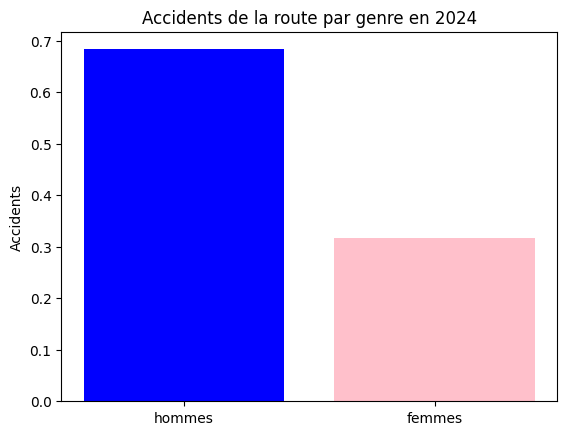

In [7]:
categories = ["hommes", "femmes"]
values = [nb_h / nb_u, nb_f / nb_u]
colors = ["blue", "pink"]

plt.ylabel("Accidents")
plt.title("Accidents de la route par genre en 2024")
plt.bar(categories, values, color=colors)
plt.show()


In [8]:
part_deces = df_u[df_u["grav"] == 4]["grav"].count() / nb_u
print(f"On a {part_deces * 100:.1f}% d'accidents de la route mortels en 2024.")

On a 40.5% d'accidents de la route mortels en 2024.


In [9]:
grav_moy = df_u["grav"].mean()
grav_moy_f = df_u_f["grav"].mean()
grav_moy_h = df_u_h["grav"].mean()

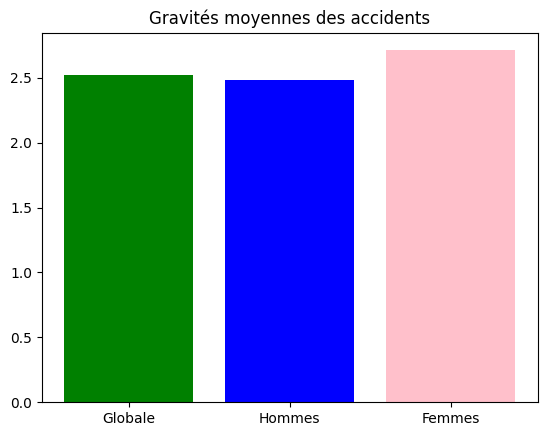

In [10]:
gravités = [grav_moy, grav_moy_h, grav_moy_f]
categories = ["Globale", "Hommes", "Femmes"]
couleurs = ["green", "blue", "pink"]

plt.bar(categories, gravités, color=couleurs)
plt.title("Gravités moyennes des accidents")
plt.show()
# Donner les écarts-types
# Sécurité moins adaptée pour les femmes ? Passagers et pas que les conducteurs.

On trouve déjà une information étonnante. Bien que les femmes soient victimes de deux fois moins d'accidents que les hommes, les accidents dont elles sont victimes sont, en moyenne, légèrement plus graves.

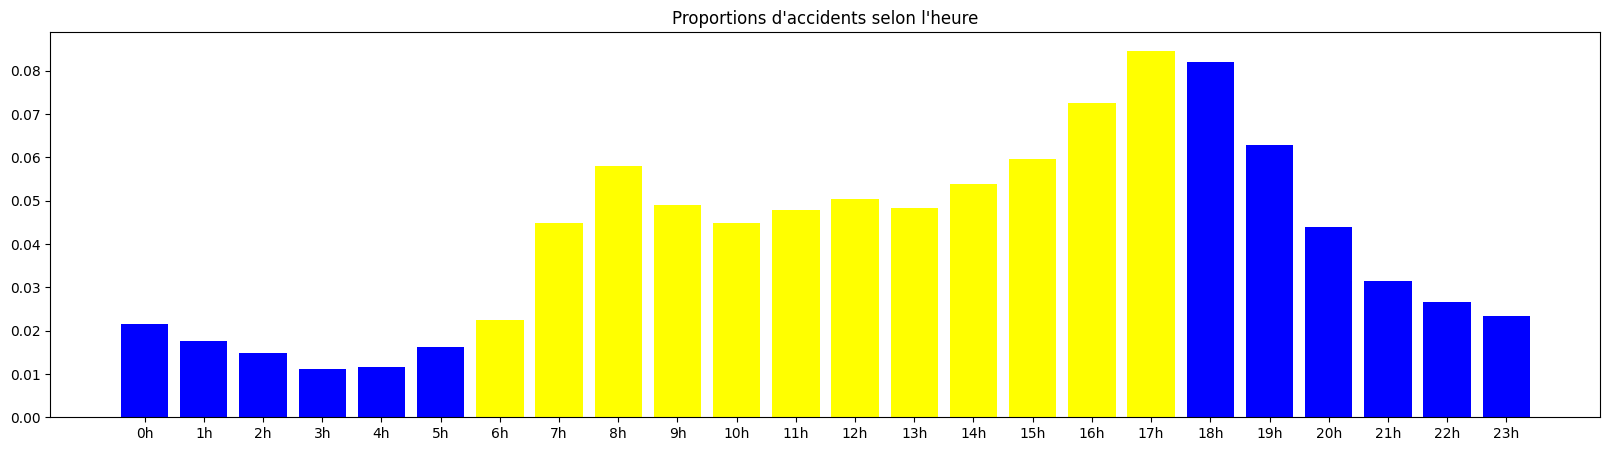

In [11]:
nb_c = df_c.count()
df_ratios_heures = df_c["hrmn"].apply(lambda s : int(s[:2])).value_counts(normalize=True)

heures = list(df_ratios_heures.sort_index())
categories = [str(k) + 'h' for k in range(24)]
couleurs = ["blue" for _ in range(6)] + ["yellow" for _ in range(12)] + ["blue" for _ in range(6)]

plt.figure(figsize=(20, 5))
plt.bar(categories, heures, color=couleurs)
plt.title("Proportions d'accidents selon l'heure")
plt.show()
# Voir s'il y a un rush hour en région ou pas

Deux phénomènes rentrent en jeu ici. D'une part, il y a très certainement beaucoup moins d'individus sur la route une fois la nuit tombée. Les pics d'accidentologie aux horaires "de pointe" (8h et 17-18h) semblent corroborer cette hypothèse. Toutefois, ceux qui roulent la nuit sont, à priori, plus en danger, et ce pour diverses raisons. On peut penser à une plus grande probabilité de conduire en étant fatigué ou ivre, ou tout simplement à cause de la visibilité réduite. 

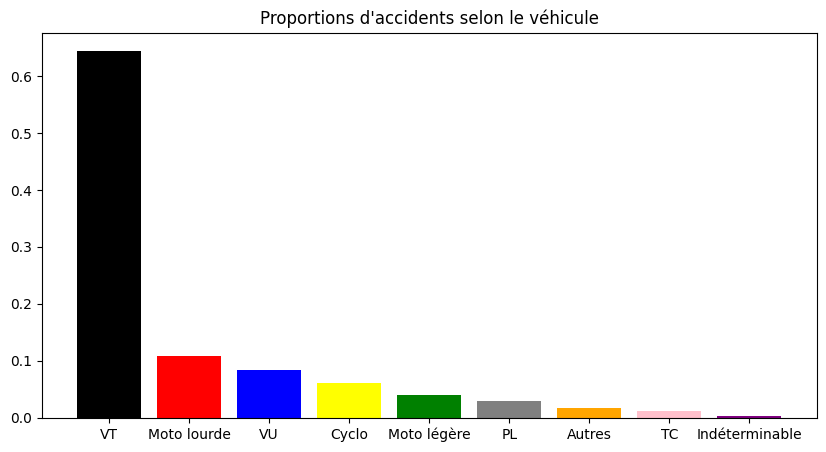

In [12]:
nb_i = df_i.count()
df_ratios_vehicules = df_i["Catégorie véhicule"].value_counts(normalize=True)

valeurs = list(df_ratios_vehicules)
categories = list(df_ratios_vehicules.index)
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple"]

plt.figure(figsize=(10, 5))
plt.bar(categories, valeurs, color=couleurs)
plt.title("Proportions d'accidents selon le véhicule")
plt.show()
# Normaliser par rapport au nombre de véhicules de chaque type en circulation
# Relativiser par rapport au référencement et à la gravité des accidents ?

Sans grande surprise, comme les voitures sont de loin le véhicule le plus utilisé, elles représentent une écrasante majorité des accidents.

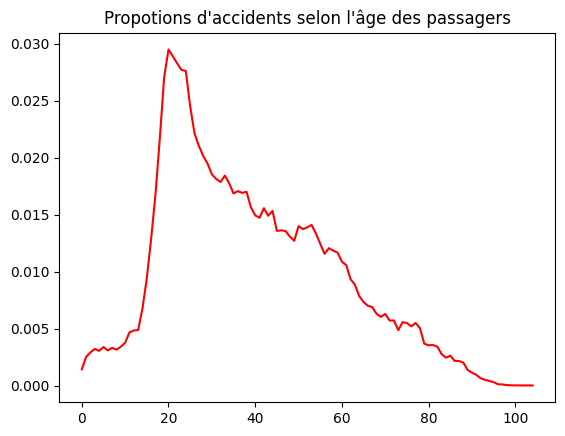

In [13]:
# Environ 2% des âges ne sont pas renseignés. Au vu de la petitesse de la valeur, nous avons d'éliminer ces lignes pour cette statistique.
df_ages = df_u["an_nais"].dropna().apply(lambda x : 2024 - int(x)).value_counts(normalize=True)
total = df_ages.count()
df_ages.sort_index()

plt.plot(list(df_ages.sort_index()), color='red')
plt.title("Propotions d'accidents selon l'âge des passagers")
plt.show()
#Corrélation entre gravité et âge.

On observe un pic de mortalité au début le vingtaine, et qui commence à se prononcer vers 15 et 16 ans, mais qui décroit brusquement vers la fin de la vingtaine, et suit une décroissance presque linéaire à partir de la trentaine. Ces observations paraissent raisonnables.

In [14]:
df_cu = pd.merge(df_c, df_u, on='Num_Acc', how='inner')
df_cu.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,3,1,2003.0,2,1,-1,-1,-1,-1,-1
1,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,1,1,1997.0,4,1,-1,-1,-1,-1,-1
2,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,3,2,1927.0,5,0,-1,-1,3,3,1
3,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,1,1,1987.0,4,1,0,-1,3,3,1
4,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,4,2,2007.0,5,8,0,-1,-1,-1,-1


In [15]:
df_grav_by_dep = df_cu.groupby('dep')['grav'].mean()
df_grav_by_dep.sort_values().head()

dep
986    2.000000
978    2.243590
40     2.288577
79     2.303665
18     2.335840
Name: grav, dtype: float64

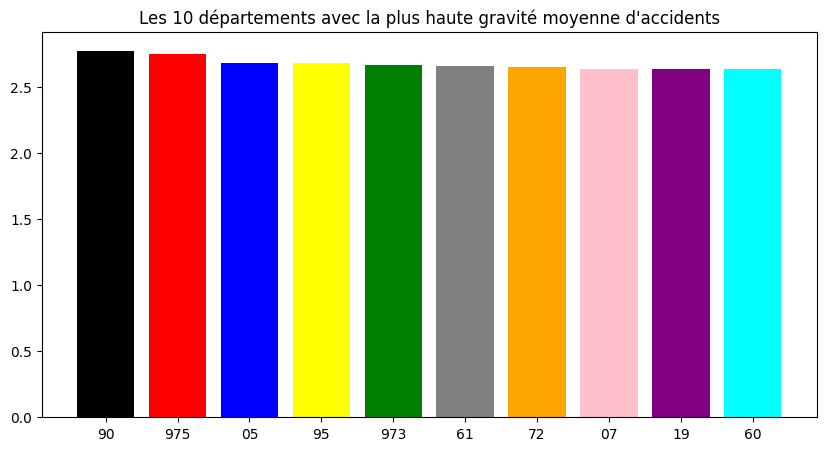

In [16]:
top_10 = df_grav_by_dep.sort_values(ascending = False)[:10]

plt.figure(figsize=(10, 5))
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple", 'cyan']
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus haute gravité moyenne d'accidents")
plt.show()

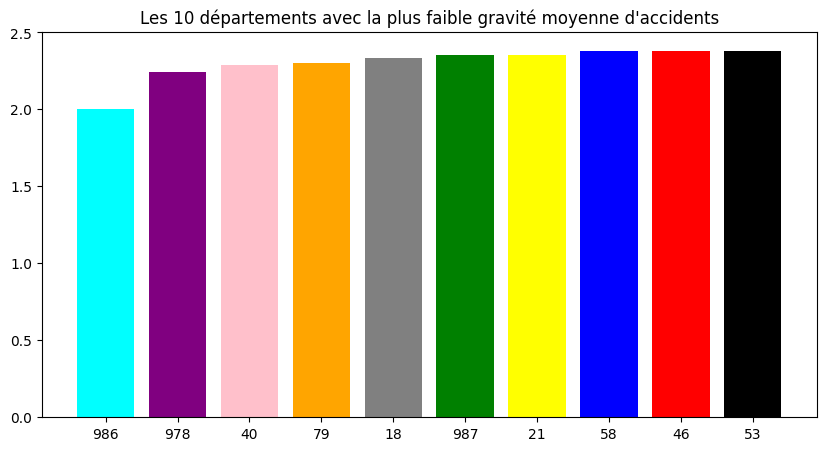

In [17]:
top_10 = df_grav_by_dep.sort_values(ascending = True)[:10]

plt.figure(figsize=(10, 5))
couleurs.reverse()
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus faible gravité moyenne d'accidents")
plt.show()
# geopandas : carte avec les départements et heatmap
# plotly pour de jolis graphes
# Scikitlearn pour le réseau de neurones

In [69]:
df_tmp = df_cu[['dep', 'sexe']].copy()
df_tmp['sexe'] -= 1
df_f = df_tmp.groupby('dep')['sexe'].sum()
df_t = df_tmp.groupby('dep').count()
df_h = df_t - df_f
#df_h

## Régressions logistiques

### Régression logistique sur le sexe seul

In [195]:
X = df_cu[["femme"]]
Y = df_cu["mortel"]

In [196]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
    stratify=Y
)

In [197]:
logreg_simple = LogisticRegression()
logreg_simple.fit(X_train, Y_train)

np.exp(logreg_simple.coef_[0])

array([0.63528476])

Ainsi, même avant de contrôler le contexte, une régression logistique ne prenant en compte que le sexe du.de la conducteur.ice montre un odds ratio de 0.6 pour les femmes, ce qui indique une probabilité d'accident mortel plus faible que pour les hommes.

### Régression logistique multivariée

À variables constantes, le sexe a-t-il un effet significatif sur la gravité de l’accident ? Il faut ici s'interroger sur l'effet des variables ommises dans la régression précédente. En effet, on peut imaginer que des variables comme l'âge, le fait qu'il fasse jour ou nuit, la conduite sur autoroute, ou l'alcoolémie puisse avoir un effet croisé (ou pas) avec le genre.

In [198]:
X = df_cu[
    ["femme", "age", "nuit"]
]
#ajouter alcool quand on arrive à identifier la catégorie en question
Y = df_cu["mortel"]

In [199]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
    stratify=Y
)

In [200]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

In [201]:
pipeline.fit(X_train, Y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [202]:
Y_pred = pipeline.predict(X_test)
Y_proba = pipeline.predict_proba(X_test)[:, 1]

In [203]:
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print("ROC AUC :", roc_auc_score(Y_test, Y_proba))

[[35753     0]
 [ 1030     0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     35753
           1       0.00      0.00      0.00      1030

    accuracy                           0.97     36783
   macro avg       0.49      0.50      0.49     36783
weighted avg       0.94      0.97      0.96     36783

ROC AUC : 0.6557223115773569


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [204]:
coefficients = pipeline.named_steps["logreg"].coef_[0]

coef_df = pd.DataFrame({
    "variable": X.columns,
    "coefficient": coefficients,
    "odds_ratio": np.exp(coefficients)
})

coef_df.sort_values("odds_ratio", ascending=False)

,variable,coefficient,odds_ratio
1,age,0.545444,1.725375
2,nuit,0.312378,1.366671
0,femme,-0.214391,0.807032


### Comparaison des résultats avec une random forest :

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [206]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, Y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [207]:
Y_pred_rf = rf.predict(X_test)
Y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [208]:
Y_test.unique()

array([0, 1])

On choisit d'utiliser la ROC AUC pour comparer les performances de la random forest et de la régression linéaire, car la ROC est robuste au déséquilibre des classes.

In [210]:
print(classification_report(Y_test, Y_pred_rf))
print("ROC AUC :", roc_auc_score(Y_test, Y_proba_rf))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     35753
           1       0.05      0.56      0.08      1030

    accuracy                           0.66     36783
   macro avg       0.51      0.61      0.44     36783
weighted avg       0.96      0.66      0.77     36783

ROC AUC : 0.6468872868024653


In [211]:
from sklearn.metrics import roc_auc_score

print("Logistique :", roc_auc_score(Y_test, Y_proba))
print("Random Forest :", roc_auc_score(Y_test, Y_proba_rf))

Logistique : 0.6557223115773569
Random Forest : 0.6468872868024653


Les deux modèles fournissent de meilleures prédictions que le hasard. En outre, même si le modèle de régression logistique multivarié est légèrement meilleur au sens de l'aire sous la courbe ROC, le gain est modeste. 

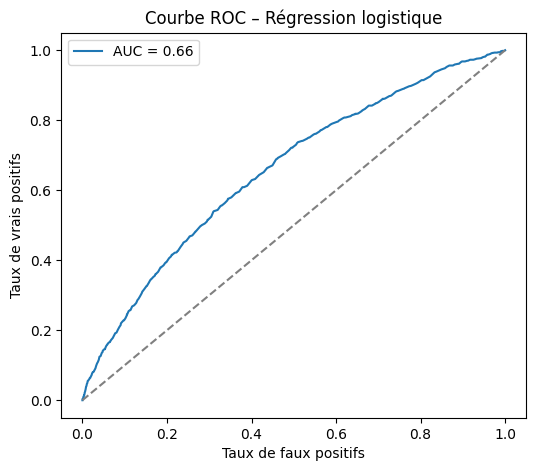

In [212]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(Y_test, Y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC – Régression logistique")
plt.legend()
plt.show()

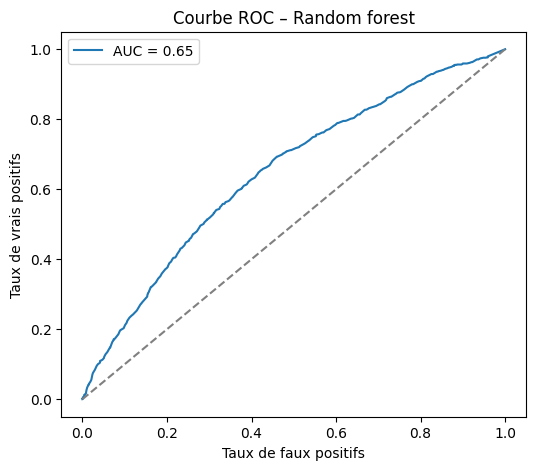

In [213]:
fpr, tpr, _ = roc_curve(Y_test, Y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC – Random forest")
plt.legend()
plt.show()

## Prédiction

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [41]:
# Prédiction d'un accident à partir du genre, de l'âge et de l'heure 
df = pd.concat([df_cu["sexe"], df_cu["an_nais"].apply(lambda n : 2024 - n), df_cu["hrmn"].apply(lambda s : int(s[:2])), df_cu[["grav"]]], axis=1).dropna()
X, y = df[["sexe", "an_nais", "hrmn"]].rename(columns={"sexe" : "sexe", "an_nais" : "âge", "hrmn" : "heure"}), df["grav"]
X_train, X_test, y_train, y_test = train_test_split(X, y)
Classifier = MLPClassifier(max_iter=1000, random_state=42).fit(X_train, y_train)

In [47]:
y_pred = Classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
score

0.4679955630953935

Prédiction de mauvaise qualité, bien que meilleure qu'un choix aléatoire, qui aurait donné 20%.